# Base Transformer Pipeline

In this notebook we will explore the basic pipeline for Training Transformer models to classify future price trends on 15min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. These stock were highly correlated around Aug - Oct 2022. The stock dataset does not contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

For this problem we will only perform predictions on the next portion of the sequence

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [35]:
from data_utils import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data
Place all stocks in a Dictionary of DataFrames

In [5]:
from glob import glob
import re

get_name = lambda x : re.search('\w+(?=_15min)', x).group()

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\*.csv'))

stock_dfs = {}
for _path in data_paths:
    _df = pd.read_csv(_path, index_col=0, parse_dates=True, infer_datetime_format=True).dropna()

    # add price_trend to each stock DataFrame
    _df = get_numeric_price_trend(_df, n=4)

    stock_dfs.update({get_name(_path) : _df})

### Determine Target Variable Thresholds

In [6]:
def get_iqr(ser):
    q1 = ser.quantile(0.25)
    q3 = ser.quantile(0.75)
    iqr = q3 - q1

    return q1, q3, iqr

def get_iqr_thresholds(x, lim=1.):
    q1, q3, iqr = get_iqr(x)

    lower = q1 - lim*iqr
    upper = q3 + lim*iqr

    return lower, upper


For each stock get upper/lower IQR thresholds to dermine price movement class

In [7]:
iqr_lim = 0.025 
thresholds = {}

for name in stock_dfs.keys():
    lower, upper = get_iqr_thresholds(stock_dfs[name]['price_trend'], iqr_lim)
    thresholds.update({name : (lower, upper)})


Plot Price Movements with lower/upper thresholds

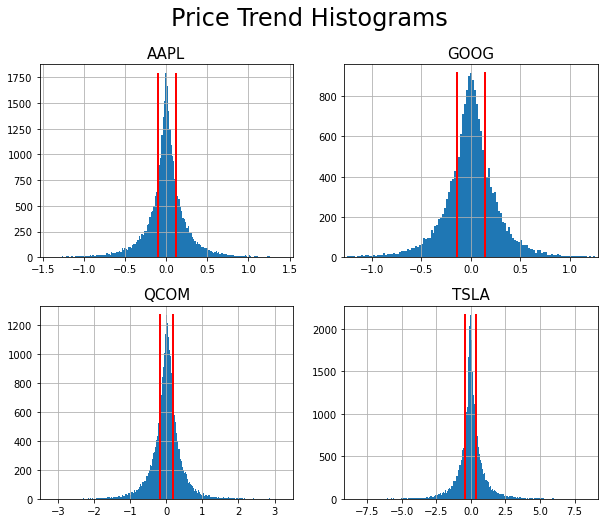

In [8]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    ax = plt.subplot(2, 2, i + 1)

    # plot Numer Price Trend Histogram
    ax_obj = stock_dfs[name]['price_trend'].hist(ax=ax, bins=500)

    # get adjust x and y limits for display purposes
    ylim = [val - val//20 for val in list(ax_obj.get_ylim())]
    xlim = [val - val//2 for val in list(ax_obj.get_xlim())]

    # plot IQR lines
    lower, upper = thresholds[name]
    ax.plot([lower, lower], ylim, color='r', linewidth=2)
    ax.plot([upper, upper], ylim, color='r', linewidth=2)

    # set xlim for nice display
    ax.set_xlim(min(xlim), -1*min(xlim))
    
    # set titles and axis labels
    fig.suptitle('Price Trend Histograms', size=24)
    ax.set_title(f'{name}', size=15)

    # add a bit of space
    fig.subplots_adjust(hspace=0.25);
    

### Add Target Variable (Price Change) to stock DataFrames

In [9]:
# supress setting with copy warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

for name in stock_dfs.keys():

    # get stock DataFrame
    df = stock_dfs[name]

    # get threshold bounds
    lower, upper = thresholds[name]

    # place target variable in DataFrame
    # obtain target variable
    df['price_change'] = 1 # price stays the same
    df['price_change'][df['price_trend'] < lower] = 0 # downward price movement
    df['price_change'][df['price_trend'] > upper] = 2 # upward prive movement

# return setting with copy warning to default 
pd.options.mode.chained_assignment = 'warn'

### FUTURE

Place plots of number of each class for each stock

### Get train, valid, test splits for each stock

In [10]:
# split into train, valid, and test sets
train = df.loc[:'2022-02-01']
valid = df.loc['2022-02-02':'2022-07-01']
test = df.loc['2022-07-01':]

In [376]:
train_dfs = {}
valid_dfs = {}
test_dfs = {}

split_dfs = {}

for name in stock_dfs.keys():

    # get stock DataFrame
    df = stock_dfs[name]

    train = df.loc[:'2022-02-01']
    valid = df.loc['2022-02-02':'2022-07-01']
    test = df.loc['2022-07-01':]


    train_dfs.update({name : train})
    valid_dfs.update({name : valid})
    test_dfs.update({name : test})
    
    split_dfs.update({name : [train, valid, test]})

In [427]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt


class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, valid_df, test_df,
                # update to take in a list of train, valid, test dfs
                batch_size=32, shuffle=False, seed=42,
                remove_labels_from_inputs=False, # update to remove any column from inputs
                label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.valid_df = valid_df
      self.test_df = test_df

      # self.train_mean = train_mean
      # self.train_std = train_std
      
      # self.position_encode = position_encode
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.seed = seed
      self.remove_labels_from_inputs = remove_labels_from_inputs

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
         self.label_columns_indices = {name: i for i, name in
                                       enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                             enumerate(train_df.columns)} # 

      # Work out the window parameters.
      self.input_width = input_width # sequence length
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # remove label from input features 
        if self.remove_labels_from_inputs:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.column_indices.keys() 
                                if name not in self.label_columns],
                axis=-1)

        # add augmented data here
        # inputs[:, 3, :]

        # we need to resample with a roughly even amount of classes

        # add position encoding to the data
        # may need to concatenate this data?
        # if self.position_encode:
        #     pos_encode = self.get_position_encoding()
        #     pos_encode = np.repeat(pos_encode[None, :, :], self.batch_size, axis=0)

        #     inputs = inputs + tf.convert_to_tensor(pos_encode)

        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def normalize(self, inputs, labels):
        ''' Standardizes each window to mean - 0 and std - 1'''
        mean = tf.math.reduce_mean(inputs, axis=1)
        std = tf.math.reduce_std(inputs, axis=1)
        
        mean = tf.repeat(tf.expand_dims(mean, axis=1), 
                         self.total_window_size, axis=1)
        std = tf.repeat(tf.expand_dims(std, axis=1), 
                        self.total_window_size, axis=1)

        inputs = tf.math.subtract(inputs, mean)
        inputs = tf.math.divide(inputs, std)

        return inputs, labels


    def get_sample_weights(self, inputs, labels):
        weights = tf.ones(shape=(32, 1))*0.33 # compute_sample_weight(class_weight='balanced', y=labels)
        weights[labels == 0] *= 1.5
        weights[labels == 2] *= 1.5
        return inputs, labels, weights

    def plot(self, data, model=None, plot_col='price_diff', max_subplots=3):
        inputs, labels = data
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
          plt.subplot(max_n, 1, n+1)
          plt.ylabel(f'{plot_col} [normed]')
          plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                  label='Inputs', marker='.', zorder=-10)

          if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
          else:
            label_col_index = plot_col_index

          if label_col_index is None:
            continue

          plt.scatter(self.label_indices, labels[n, :, label_col_index],
                      edgecolors='k', label='Labels', c='#2ca02c', s=64)
          if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

          if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

    # WindowGenerator.plot = plot
    
    
    def get_position_encoding(self, n=10000):
        d = self.train_df.shape[1] # assume all features are used
        pos_encode = np.zeros((self.input_width, d))
        for k in range(self.input_width):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                pos_encode[k, 2*i] = np.sin(k/denominator)
                pos_encode[k, 2*i+1] = np.cos(k/denominator)
        return pos_encode

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=self.shuffle,
                seed=self.seed,
                batch_size=self.batch_size)

        ds = ds.map(self.split_window)
        ds = ds.map(self.normalize)
        ds = ds.map(self.get_sample_weights)

        return ds

    # WindowGenerator.make_dataset = make_dataset
    

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    # WindowGenerator.train = train
    # WindowGenerator.valid = valid
    # WindowGenerator.test = test
    # WindowGenerator.example = example

In [428]:
aapl_gen = WindowGenerator(
                input_width=32, label_width=1, shift=0, 
                train_df=train_dfs['AAPL'], valid_df=valid_dfs['AAPL'], test_df=test_dfs['AAPL'],
                remove_labels_from_inputs=True, batch_size=32, 
                label_columns=['price_change'])

In [429]:
for inputs, targets, weights in aapl_gen.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Targets shape (batch, time, features): {targets.shape}')

ValueError: in user code:

    File "C:\Users\itber\AppData\Local\Temp\ipykernel_22796\1987049789.py", line 114, in get_sample_weights  *
        weights[labels == 0] *= 1.5

    ValueError: Shapes (32, 1) and (None, 1, 1) are incompatible


In [423]:
y_train = np.random.randint(low = 0, high = 5, size = (32,6), dtype = np.int32)
compute_sample_weight(class_weight='balanced', y=y_train).shape

(32,)

### Start Training Models

In [406]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [407]:
single_step_aapl = WindowGenerator(
        input_width=1, label_width=1, shift=0,
        train_df=train_dfs['AAPL'], valid_df=valid_dfs['AAPL'], test_df=test_dfs['AAPL'],
        remove_labels_from_inputs=False, batch_size=32, 
        label_columns=['price_change'])

In [408]:
single_step_aapl

Total window size: 1
Input indices: [0]
Label indices: [0]
Label column name(s): ['price_change']

In [367]:
baseline = Baseline(label_index=single_step_aapl.column_indices['price_change'])

baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

train_performance = {}
val_performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_aapl.train)
val_performance['Baseline'] = baseline.evaluate(single_step_aapl.valid)

208/208 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3090


Stream line the process with a conveincence function

In [409]:
def compile_and_fit(model, window, lr=1e-4, max_epochs=100, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])

    # TEMP
    class_weight = {0: 1.,
                1: 50.,
                2: 2.}
    sample_weight = np.ones(shape=(32, 1))
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.valid,
                        callbacks=[early_stopping])
    return history

In [410]:
transformer_model = TransformerModel(
            n_heads=2,
            d_model=512,
            ff_dim=256,
            num_transformer_blocks=2,
            mlp_units=[256],
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1)

In [411]:
compile_and_fit(transformer_model, aapl_gen, lr=1e-4,
                patience=2, max_epochs=2)

train_performance['transformer'] = transformer_model.evaluate(aapl_gen.train)
val_performance['transformer'] = transformer_model.evaluate(aapl_gen.valid)

Epoch 1/2
637/638 [============================>.] - ETA: 0s - loss: 0.8304 - accuracy: 0.6189

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/weighted_loss/Mul' defined at (most recent call last):
    File "c:\Users\itber\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\itber\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\itber\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\itber\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\itber\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\itber\AppData\Local\Temp\ipykernel_22796\3341352332.py", line 1, in <cell line: 1>
      compile_and_fit(transformer_model, aapl_gen, lr=1e-4,
    File "C:\Users\itber\AppData\Local\Temp\ipykernel_22796\4111172134.py", line 15, in compile_and_fit
      history = model.fit(window.train, epochs=max_epochs,
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 140, in __call__
      return losses_utils.compute_weighted_loss(
    File "c:\Users\itber\anaconda3\envs\tf\lib\site-packages\keras\utils\losses_utils.py", line 328, in compute_weighted_loss
      weighted_losses = tf.multiply(losses, sample_weight)
Node: 'sparse_categorical_crossentropy/weighted_loss/Mul'
required broadcastable shapes
	 [[{{node sparse_categorical_crossentropy/weighted_loss/Mul}}]] [Op:__inference_train_function_51699]

In [392]:
val_performance

{'Baseline': [nan, 0.3090006113052368],
 'transformer': [0.5551953911781311, 0.7766520380973816]}